# Generation of Synthetic Promoter Library

# Introduction

This notebook generates a synthetic promoter library for *P. putida* on the basis of promoter BG14g ([Zobel et al., 2015](https://doi.org/10.1021/acssynbio.5b00058)). The synthetic promoters are generated within the distance that has been experimentaly sampled.

## System initiation

Loading all necessary libraries.

In [1]:
import os
import pandas as pd
import joblib
import pickle
import itertools
import random
import numpy as np
import time
import matplotlib.pyplot as plt

from ExpressionExpert_Functions import Data_Src_Load, Sequence_Conserved_Adjusted, Insert_row_, ExpressionStrength_HeatMap, SequenceRandomizer_Parallel, Sequence_Ref_DiffSum, list_onehot, list_integer
%matplotlib inline

### Variable setting

We load the naming conventions from 'config.txt'

In [2]:
Name_Dict = dict()
with open('config_EcolPtai.txt') as Conf:
    myline = Conf.read().splitlines()
    for line in myline:
        if not line.startswith('#'):
            (key, val) = line.split(':', 1)
            Name_Dict[str(key.strip())] = val.strip()
        

Data_File = Name_Dict['Data_File']
# extract the filename for naming of newly generated files
File_Base = Name_Dict['File_Base']
# the generated files will be stored in a subfolder with custom name
Data_Folder = Name_Dict['Data_Folder']
# column name of expression values
Y_Col_Name = eval(Name_Dict['Y_Col_Name'])
# figure file type
Fig_Type = Name_Dict['Figure_Type']

## Data loading

General information on the data source csv-file is stored in the 'config.txt' file generated in the '0-Workflow' notebook. The sequence and expression data is stored in a csv file with an identifier in column 'ID' (not used for anything), the DNA-sequence in column 'Sequence', and the expression strength in column 'promoter activity'. While loading, the sequence is converted to a label encrypted sequence, ['A','C','G','T'] replaced by [0,1,2,3], and a one-hot encoding.

In [3]:
SeqDat = Data_Src_Load(Name_Dict)
SeqDat.head(3)

,Strain ID Ecol,Strain ID Ptai,Sequence,Ecol Promoter Activity,Ptai Promoter Activity,Sequence_label-encrypted,Sequence_letter-encrypted
0,SN_rep3 20180122,SynPro35_1,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",0.043,0.014,"[3, 3, 3, 0, 3, 3, 3, 2, 0, 1, 0, 3, 2, 1, 2, ...",TTTATTTGACATGCGTGATGTTTAGAATTATAATTTGGGG
1,SN_rep3 20180123,SynPro35_2,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",0.033,0.015,"[3, 3, 3, 0, 3, 3, 3, 2, 0, 1, 0, 3, 2, 1, 2, ...",TTTATTTGACATGCGTGATGTTTAGAATTATAATTTGGGG
2,SN_rep3 20180124,SynPro35_3,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",0.036,0.018,"[3, 3, 3, 0, 3, 3, 3, 2, 0, 1, 0, 3, 2, 1, 2, ...",TTTATTTGACATGCGTGATGTTTAGAATTATAATTTGGGG


## Setting of exploration boundaries

### Extraction of experimentaly tested sequence positions

In [4]:
# removing non-informative positions where no base diversity exists, base one hot encoding
SeqDat_Hadj, Positions_removed, PSEntropy = Sequence_Conserved_Adjusted(SeqDat, Name_Dict)

# removing non-informative positions where no base diversity exists, based one hot encoding
idx = 0
Measure_Name = Y_Col_Name[idx]
# Expression_Column = '{}_scaled'.format(Measure_Name)
Expr_avg = ExpressionStrength_HeatMap(SeqDat_Hadj, Measure_Name)
Expr_avg = Insert_row_(Positions_removed, Expr_avg, np.zeros([len(Positions_removed),4])*np.nan)

Seq_Pos_Sampled = Expr_avg.notnull().astype('int')


Z:\Documents\Biocarb\models\data\1911_ExpressionExpert.ipynb\ExpressionExpert_Functions.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1.loc[idx]=element


In [5]:
# First the positions for nucleotide exchanges are determined
# The maximum sequence distance for experimentaly teste sequences to the reference was four nucleotides (cf. histogram of sequence distance in the statistical analysis notebook)
# We require an minimum positional entropy of 0.15 bit to assume sufficient sampling for reasonable prediction accuracy (cf. position entropy in the statistical analysis notebook)
# The random forest machine learner has assigned reasonable feature importance only to regions [-35 - -30] and [-12 - -7]
# Hence, mutations are only assigned to positions [-35, -34, -30, -10, -9, -8]
# For each position the following amount of nucleotides were tested [-35:4, -34:4, -30:3, -10:4, -9:3, -8:4]
# In total 2304 combinations are possible, these are further constrained by the maximum nucleotide distance to the reference sequence

Sequence_Distance_cutoff = float(Name_Dict['Sequence_Distance_cutoff'])
Position_Diversity_cutoff = float(Name_Dict['Position_Diversity_cutoff'])
Synth_Seq_MaxNumber = int(Name_Dict['Synth_Seq_MaxNumber'])

# Reference promoter sequence
if Name_Dict['RefSeq'] is not '':
    RefSeq = Name_Dict['RefSeq']
    print('use reference sequence')
else:    
    # using the one-hot encoding the most common nucleotide on each position is calculated.
    Alphabet = ['A','C','G','T']
    Pos_Nucl_Sum = np.sum(np.dstack(SeqDat['Sequence'].values), axis=2)
    RefSeq_list = list([Alphabet[Pos_idx] for Pos_idx in np.argmax(Pos_Nucl_Sum, axis=1)])
    RefSeq = ''.join(RefSeq_list)
print('Reference sequence:', RefSeq)

# Nucleotides that can be randomized because they sampling is above the entropy threshold
Pos_random = -1*(len(RefSeq)-np.arange(PSEntropy.shape[0])[PSEntropy>Position_Diversity_cutoff])
Base_SequencePosition = Seq_Pos_Sampled.iloc[Pos_random]
print('Relevant positions and tested nucleotides')
print(Base_SequencePosition)
# calculating how many different sequences exist
# we check how many bases for each sufficiently sampled position are possible
# combinatorics gives the final answer
mybases, mycount = np.unique(np.sum(Base_SequencePosition.values, axis=1), return_counts=True)
Comb_Numb = np.prod(np.power(mybases, mycount))
print('Overall number of possible sequences:', Comb_Numb)



use reference sequence
Reference sequence: GCCCATTGACAAGGCTCTCGCGGCCAGGTATAATTGCACG
Relevant positions and tested nucleotides
     A  C  G  T
-31  1  1  1  1
-30  1  1  1  1
-29  1  1  1  1
-28  1  1  1  1
-27  1  1  1  1
-26  1  1  1  1
-25  1  1  1  1
-24  1  1  1  1
-23  1  1  1  1
-22  1  1  1  1
-21  1  1  1  1
-20  1  1  1  1
-19  1  1  1  1
-18  1  1  1  1
-17  1  1  1  1
-16  1  1  1  1
-15  1  1  1  1
-14  1  1  1  1
-13  1  1  1  1
-10  1  1  1  1
-9   1  1  1  1
-8   1  1  1  1
Overall number of possible sequences: 17592186044416


In [6]:
# if the space of possible sequences is lower than the maximum limit space, each sequences is generated
# if the space of possible sequences is larger than the maximum limit space, random sequences within the exploratory space are generated

if Comb_Numb < Synth_Seq_MaxNumber:
    # Deletion of non-tested nucleotides
    Pos_rand_numb = len(Pos_random)
    Alphabet = ['A','C','G','T']
    Seq_Base = np.tile(Alphabet, [Pos_rand_numb, 1]).tolist()
    # identification of positions where not all four nucleotides were tested
    Pos_Del, Nucl_Del = np.where(Seq_Pos_Sampled.iloc[Pos_random].values == 0)
    # replacing all nucleotides to be replaced by an 'X'
    myArr = np.array(Seq_Base)
    myArr[tuple([Pos_Del,Nucl_Del])] = 'X'
    Position_list = myArr.tolist()
    Seq_Base = list()
    for Position in Position_list:
        Seq_Base.append(list(set(Position).difference(set('X'))))
    Seq_Base_comb = list(itertools.product(*Seq_Base))
    for index in Pos_random+40: #+40
        RefSeq_list[index] = '{}'
    RefSeq_base = ''.join(RefSeq_list)
    # setting up the final promoter list
    Seq_Base_comb = [RefSeq_base.format(*Nucleotide_replace) for Nucleotide_replace in Seq_Base_comb]

    print('generated sequences: ',len(Seq_Base_comb))
else:
    Seq_Base_comb = SequenceRandomizer_Parallel(RefSeq, Base_SequencePosition, n=Synth_Seq_MaxNumber)
    


### Measuring synthetic sequence distance to reference

#### Generating arche-type reference
The reference is generated as the most commonly tested nucleotides on each position.

use reference sequence
Reference sequence: GCCCATTGACAAGGCTCTCGCGGCCAGGTATAATTGCACG
Number of sequences with less than 40% nucleotide changes to the reference: 2958


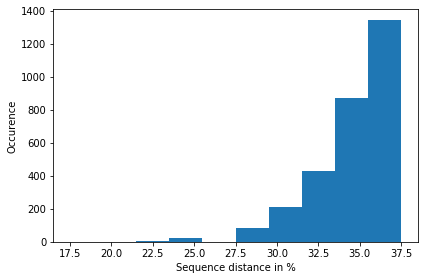

In [7]:
# setting up the full promoters
# Reference promoter sequence
# using the one-hot encoding the most common nucleotide on each position is calculated.

# For histogram of sequence diversity you can either root the distance to the most common nucleotide on each position or provide an external reference
if Name_Dict['RefSeq'] is not '':
    RefSeq = Name_Dict['RefSeq']
    print('use reference sequence')
else:    
    # using the one-hot encoding the most common nucleotide on each position is calculated.
    Alphabet = ['A','C','G','T']
    Pos_Nucl_Sum = np.sum(np.dstack(SeqDat['Sequence'].values), axis=2)
    RefSeq_list = list([Alphabet[Pos_idx] for Pos_idx in np.argmax(Pos_Nucl_Sum, axis=1)])
    RefSeq = ''.join(RefSeq_list)

print('Reference sequence:', RefSeq)

# # RefSeq = SeqDat['Sequence_letter-encrypted'][0]
# # RefSeq_list = list(RefSeq) #int(Pos_random+40)
# for index in Pos_random+40: #+40
#     RefSeq_list[index] = '{}'
# RefSeq_base = ''.join(RefSeq_list)
# # setting up the final promoter list
# SynMatrix_full = [RefSeq_base.format(*Nucleotide_replace) for Nucleotide_replace in Seq_Base_comb]
SynMatrix_full = Seq_Base_comb

# determining the amino acid substitutions of the snythetic promoters relative to the reference promoter
SeqDat_wRef = SynMatrix_full.copy()
SeqDat_wRef.insert(0, RefSeq)
RefSeq_Dist = Sequence_Ref_DiffSum(SeqDat_wRef)
NearDist_Bool = np.array(RefSeq_Dist)<Sequence_Distance_cutoff

RefSeq_NearDist = RefSeq_Dist[NearDist_Bool]
SynSeq_NearDist = np.array(SynMatrix_full)[NearDist_Bool]
SynSeq_ND_numb = SynSeq_NearDist.shape[0]
print('Number of sequences with less than {:.0f}% nucleotide changes to the reference: {}'.format(Sequence_Distance_cutoff*100, SynSeq_ND_numb))

plt.hist(RefSeq_NearDist*100) # BG42: [3,6:221]; BG35:[2,222:]
plt.xlabel('Sequence distance in %')
plt.ylabel('Occurence')
plt.tight_layout()
Fig_ID = Name_Dict['SampSeqDist_File']
SampSeqDist_File = os.path.join(Data_Folder, '{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Fig_Type))
# plt.savefig(SampSeqDist_File, bbox_inches='tight', format=Fig_Type)
plt.show()

### Removing measured sequences from library

In [8]:
Seq_Measured = np.unique(SeqDat['Sequence_letter-encrypted'].values)
print('Number of different promoter sequences measured: ', Seq_Measured.shape[0])

MeasSeq_Idx = [list(np.arange(SynSeq_ND_numb)[SynSeq_NearDist == np.array(SeqMeas.upper())]) for SeqMeas in Seq_Measured]
MeasSeq_Idx = np.unique(np.asarray(list(filter(None, MeasSeq_Idx))))
print('Library sequences already measured: ', MeasSeq_Idx)
# Some sequences are often repeatedly measured in the experiments, e.g. sequence 1116 in 'SynSeq_NearDist'
# print('Sequence of synthetic sequence 1116 measured 93 times', SynSeq_NearDist[1116])

# deletion of measured sequences
SynSeq_NearDist = np.delete(SynSeq_NearDist, MeasSeq_Idx)
print('Number of new sequences in exploratory region: ', SynSeq_NearDist.shape[0])

Number of different promoter sequences measured:  95
Library sequences already measured:  []
Number of new sequences in exploratory region:  2958


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


## Synthetic library expression strength

In [9]:
Measure_Numb = int(Name_Dict['Library_Expression'])
SynSeq_df = pd.DataFrame({'Sequence': SynSeq_NearDist})

for Meas_Idx in range(Measure_Numb):
    print('Random Forest Regression of', Y_Col_Name[Meas_Idx])
    
    # loading the random forest model
    ML_ID = Name_Dict['RFR_ML_File']
    ML_Date = Name_Dict['RFR_Date']
    Regressor_File = os.path.join(Data_Folder, '{}_{}_{}_{}.pkl'.format(ML_Date, File_Base, Y_Col_Name[Meas_Idx].replace(' ','-'), ML_ID))
    RFR_Best = joblib.load(Regressor_File)
    
    # loading random forest parameters
    Param_ID = Name_Dict['RFR_Params_File']
    Parameter_File = os.path.join(Data_Folder, '{}_{}_{}_{}.pkl'.format(ML_Date, File_Base, Y_Col_Name[Meas_Idx].replace(' ','-'), Param_ID))
    RFR_Params = pickle.load(open(Parameter_File, 'rb'))
    
    Positions_removed = RFR_Params['Positions_removed']
    Scaler_DictName = '{}_Scaler'.format(Y_Col_Name[Meas_Idx])
    Expr_Scaler = RFR_Params[Scaler_DictName]
    
    # prediction of expression strength
    n = len(SynSeq_NearDist)
    X_Test = np.array(list_onehot(np.delete(list_integer(SynSeq_NearDist),Positions_removed, axis=1))).reshape(n,-1)  
    Y_Test_norm = RFR_Best.predict(X_Test)
    Y_Test = Expr_Scaler.inverse_transform(Y_Test_norm)
    SynSeq_df[Y_Col_Name[Meas_Idx]] = Y_Test

SynSeq_df = SynSeq_df.sort_values(by=Y_Col_Name[0])    
Csv_ID = Name_Dict['Csv_ID']
SynCsv_File = os.path.join('{}_{}_{}.csv'.format(time.strftime('%Y%m%d'), File_Base, Csv_ID)) #'data-PromLib_EcolPtai\\TillTest_predicted.xlsx'     
SynSeq_df.to_csv(SynCsv_File, index=None)


Random Forest Regression of Ecol Promoter Activity
Random Forest Regression of Ptai Promoter Activity


### Generating new config file for analysis of synthetic library

In [10]:
# constructing the config_synth.txt file
Name_Dict['Data_File'] = SynCsv_File
with open('config_synth.txt', 'w') as f:
    print('# This file contains the naming conventions for all output files. It is automatically generated when going through step "0-Workflow".', file=f)
    for key, value in Name_Dict.items():
        print('{}: {}'.format(key, value), file=f)